In [399]:
dataset_path = '/kaggle/input/sample/corpus.txt'
with open (dataset_path) as f:
    data = f.read ()

In [400]:
print (data[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [411]:
def generate_corpus (input_file):
    corpus = list ()
    with open (input_file, 'r') as f:
        text = f.read ()
        
        tokens = re.split (r'(\s+)', text)
        
        for token in tokens:
            if token:
                corpus.append(token)
    
    return corpus

input_file = '/kaggle/input/sample/corpus.txt'
corpus = generate_corpus (input_file)

In [401]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [410]:
tokens = sorted (list (set (corpus)))

In [450]:
ttoi = { t: i for i, t in enumerate (tokens) }
ttoi[''] = -1
itot = { i: t for t, i in ttoi.items () }

def encode (text: str):
    encoded = list ()
    tokens = re.split (r'(\s+)', text)
    for t in tokens:
        encoded.append (ttoi[t])
    return torch.tensor (encoded)

def decode (tensor: torch.Tensor):
    decoded = ''
    for t in tensor:
        decoded += itot[t.item ()]
    return decoded

In [451]:
decode (encode ('there is a very'))

'there is a very'

In [746]:
X = encode (''.join (corpus))
X.shape

torch.Size([405303])

In [747]:
vocab_size = len (tokens)
vocab_size, X.shape

(25677, torch.Size([405303]))

In [894]:
ctx = 4
batch_size = 64
n_embd = 256
n_head = 8
n_layer = 2

In [749]:
n_train = int (X.shape[0] * 0.80)
n_dev = int (X.shape[0] * 0.10)

train = X[:n_train]
dev = X[n_train:n_train + n_dev]
test = X[n_train + n_dev:]

train.shape[0] + dev.shape[0] + test.shape[0] == X.shape[0]

True

In [750]:
def fetch_batch (split_type: str):
    split_map = {
        'train': train,
        'dev': dev,
        'test': test
    }
    
    data = split_map[split_type]
    ix = torch.randint (0, data.shape[0] - ctx, (batch_size, ))
    inputs = torch.stack ([data[i:i + ctx] for i in ix])
    outputs = torch.stack ([data[i + 1:i + ctx + 1] for i in ix])
    
    return inputs.clone (), outputs.clone ()

In [462]:
!pip install pykan
from kan import *

In [907]:
class MultiHeadAttention (nn.Module):
    def __init__ (
        self,
        n_embd: int,
        n_head: int
    ):
        super (MultiHeadAttention, self).__init__ ()
        
        self.n_head = n_head
        self.n_embd = n_embd
        self.qkv = nn.Linear (n_embd, 3 * n_embd)
        
    def forward (self, x):
        batch, ctx, n_embd = x.shape
        
        q, k, v = self.qkv (x).split (n_embd, dim=-1)
        q = q.view (batch, ctx, self.n_head, n_embd // self.n_head).transpose (1, 2)
        k = k.view (batch, ctx, self.n_head, n_embd // self.n_head).transpose (1, 2)
        v = v.view (batch, ctx, self.n_head, n_embd // self.n_head).transpose (1, 2)
        
        attn = F.scaled_dot_product_attention (q, k, v, is_causal=True)
        attn = attn.transpose (2, 1)
        o = attn.view (batch, ctx, n_embd)
        
        return o

In [908]:
class Block (nn.Module):
    def __init__ (
        self,
        n_embd: int,
        n_head: int
    ):
        super (Block, self).__init__ ()
        
        self.mha = MultiHeadAttention (n_embd, n_head)
        self.ffn = nn.Sequential (
            nn.Linear (n_embd, 4 * n_embd),
            nn.GELU (),
            nn.Linear (4 * n_embd, n_embd),
            nn.Dropout (0.2)
        )
        
    def forward (self, x):
        x = torch.relu (self.mha (x))
        o = self.ffn (x)
        
        return o

In [909]:
class Transformer (nn.Module):
    def __init__ (
        self,
        n_embd: int,
        n_layer: int,
        vocab_size: int,
        ctx: int,
        n_head: int
    ):
        super (Transformer, self).__init__ ()
        
        self.wte = nn.Embedding (vocab_size, n_embd)
        self.wpe = nn.Parameter (torch.ones (1, ctx, n_embd), requires_grad=True)
        
        self.layers = nn.Sequential (*[
            Block (n_embd, n_head) for _ in range (n_layer)
        ])
        
        self.project = nn.Linear (n_embd, vocab_size)
        
    def forward (self, x):
        x = self.wte (x)
        inputs = x + self.wpe
        output = self.layers (inputs)
        logits = self.project (output)
        return logits

# debugging

In [910]:
X, yhat = fetch_batch ('dev')
X.shape

torch.Size([64, 4])

In [32]:
wte = nn.Embedding (vocab_size, n_embd) (X)
wte.shape

torch.Size([64, 4, 128])

In [ ]:
wpe = nn.Parameter (torch.ones (1, ctx, n_embd), requires_grad=True)
inputs = wpe + wte
inputs.shape

In [ ]:
batch, ctx, n_embd = inputs.shape

In [ ]:
qkv = nn.Linear (n_embd, 3 * n_embd) (inputs)
qkv.shape

In [ ]:
q, k, v = qkv.split (n_embd, dim=-1)
q.shape

In [ ]:
q = q.view (batch, ctx, n_head, n_embd // n_head).transpose (1, 2)
k = k.view (batch, ctx, n_head, n_embd // n_head).transpose (1, 2)
v = v.view (batch, ctx, n_head, n_embd // n_head).transpose (1, 2)

In [ ]:
q.shape

In [ ]:
attn = F.scaled_dot_product_attention (q, k, v, is_causal=True)
attn = attn.transpose (1, 2)
attn.shape

In [ ]:
o = attn.view (batch, ctx, n_embd)
o.shape

In [ ]:
o = o.view (-1, 128)
o.shape

In [ ]:
o = KANLayer (n_embd, 2 * n_embd) (o)
o = KANLayer (2 * n_embd, n_embd) (o[0])
o = o[0].view (batch, ctx, n_embd)
o.shape

# training

In [985]:
model = Transformer (
    n_embd,
    n_layer,
    vocab_size,
    ctx,
    n_head
)

In [986]:
device = 'cuda'

In [987]:
model = model.to (device)
model = nn.DataParallel (model)

In [988]:
epochs = 2000
lr = 0.001

In [989]:
criterion = nn.CrossEntropyLoss ()
optimizer = torch.optim.AdamW (model.parameters (), lr=lr, weight_decay=0.1)

In [990]:
lossi = list ()
lris = list ()

In [991]:
for e in range (epochs):
    X, yhat = fetch_batch ('train')
    
    X = X.to (device)
    yhat = yhat.to (device)
    
    optimizer.zero_grad (set_to_none=True)
    o = model (X)
    loss = criterion (o.view (batch_size * ctx, vocab_size), yhat.view (batch_size * ctx))
    loss.backward ()
    optimizer.step ()
    lossi.append (loss.item ())
    
    if e == 0 or (e + 1) % 100 == 0:
        print (f'Epoch: {e + 1}, Loss: {loss.item ()}')

Epoch: 1, Loss: 10.178685188293457
Epoch: 100, Loss: 4.178338527679443
Epoch: 200, Loss: 4.191445827484131
Epoch: 300, Loss: 4.0516886711120605
Epoch: 400, Loss: 3.911832094192505
Epoch: 500, Loss: 4.049639701843262
Epoch: 600, Loss: 3.787393808364868
Epoch: 700, Loss: 3.550013303756714
Epoch: 800, Loss: 3.882927894592285
Epoch: 900, Loss: 3.9576566219329834
Epoch: 1000, Loss: 3.606595754623413
Epoch: 1100, Loss: 3.7443814277648926
Epoch: 1200, Loss: 3.6637396812438965
Epoch: 1300, Loss: 3.6615917682647705
Epoch: 1400, Loss: 3.7279677391052246
Epoch: 1500, Loss: 3.573021411895752
Epoch: 1600, Loss: 3.7401607036590576
Epoch: 1700, Loss: 3.6695938110351562
Epoch: 1800, Loss: 3.7031075954437256
Epoch: 1900, Loss: 3.5303587913513184
Epoch: 2000, Loss: 3.870863437652588


In [992]:
import numpy as np
import matplotlib.pyplot as plt

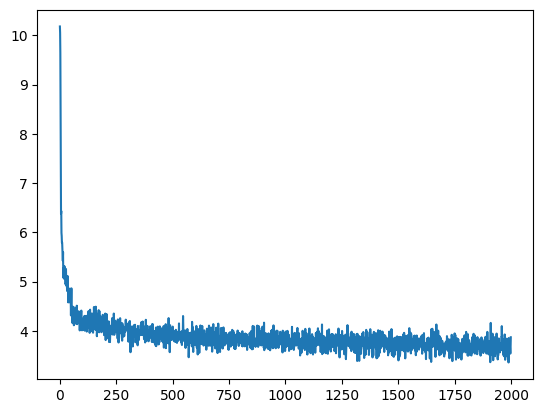

In [993]:
steps = np.arange (0, epochs)
plt.plot (steps, lossi)

In [994]:
def generate(
    input_token=test[:ctx].unsqueeze (0).to (device),
    max_tokens=1000,
) -> torch.Tensor:
    for t in range(max_tokens):
        input = input_token[:, -ctx:]
        out = model (input) # model gives out torch.Size([1, 4, 301829])
        out = out[:, -1, :]
        out = F.softmax(out, dim=-1)
        next = torch.multinomial(out, num_samples=1)
        print (decode (next), end='')
        input_token = torch.cat((input_token, next), dim=-1)
    return input_token

In [995]:
out = generate ()
out.shape

him may to no fellow, here!
Why your worship.

QUEEN:
The marks by Rome.
And in haunt my hour you dear!
into me will am that have unto our to-day,

KING EDWARD IV:
God the suspects.
harsh, Alack, bring who, thou my Yourself,

KING EDWARD in the upper

FLORIZEL:
Should cannot have, and to will hast the roots you shall God to dead.
driven thou against the king.

KING EDWARD IV:
What, am I shall are more, of our battlements if to my power.

CAPULET:
For this sullen
Gentle her ghost
release it the king's as courts with can after,
gentlemen. not thy rest he, I may post-haste, in plackets am mine blood
Why, we can had an wast a windows to do you yet QUEEN ELIZABETH:
Speak of a join of lie it now
to be chances

Messenger:
Which in perform
Brother, it live, when that went me and exile us do't not have the untried dead,

ROMEO:
Ay, the comfort I may both you take to my drooping at a highness tongues,
strawberries. York too danger and is forsworn Sandal my sad tell taught I would unconstant.

GL

torch.Size([1, 1004])